# Dynamic Weight Majority Algorithm

This notebook is an implementation of the DNW algorithm with Naive-Bayes models <br />

First I present the algorithm, I explain its steps and then i present the implementation with evalutation results.<br />
At the same time I create the initial test dataset to use.<br />
## Presentation of the Algorithm: 

### Inputs: 

A) {x,y}: Feature vectors and class labels <br />
B) c : Number of classes <br />
C) β : factor for decreasing weights<br />
D) θ : threshold for deleting experts<br />
E) p : period for expert removal <br />

### Outputs: <br />

A) Λ : global predictions

**START** <br />

m ← 1       &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;  ( m = number of experts )<br />
e1 ← Create_New_Expert() <br />
wm ← 1   &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;( wm = weight of expert m ) <br />  <br />

**FOR** i **OVER** n : ( n = number of feature vectors ) <br /> 
&emsp;σ ← 0 &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;( σ = sum of weighted predictions for each class) <br /> <br /> 
&emsp;**FOR** j **OVER** m :    <br /> 
&emsp;&emsp; λ ← Predict( ej , xi ) &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; ( expert ej will try to classify feature xi) <br /> 
&emsp;&emsp;**IF (** λ != yi **AND** i **MOD** p = 0 **) THEN** : <br /> 
&emsp;&emsp;&emsp;wj ← β * wj  <br />
&emsp;&emsp;σλ ← σλ +wj <br />
&emsp;Λ ← argmaxj σj <br /><br />

&emsp;**IF (** i **MOD** p = 0 **) THEN**: &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; ( check if need to remove or add experts ) <br/>
&emsp;&emsp;w ← Normalize-Weights(w) <br/>
&emsp;&emsp;{e,w} ← Remove-Experts({e,w},θ) <br/>
&emsp;&emsp;**IF (** Λ != yi **) THEN** : <br/>
&emsp;&emsp;&emsp;m ← m+1 <br/>
&emsp;&emsp;&emsp;em ← Create-New-Expert() <br/>
&emsp;&emsp;&emsp;wm ← 1<br/><br/>

&emsp;**FOR** j **OVER** m :    <br /> 
&emsp;&emsp;e j ← Train(ej,xi,yi)<br/>
&emsp;**OUTPUT** Λ <br /> 

**END** <br />


### Imports

In [1]:
import pandas as pd
import numpy as np
from random import seed
import random
from sklearn import preprocessing

from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm, tnrange

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

### Important functions

In [2]:
def newLearner(concept):
  if concept == "Stagger":
    learner = BernoulliNB()
  else:
    learner = GaussianNB()
  return learner

In [3]:
def normalize(w):
    
    maximum = np.max(w)
    for i in range(len(w)):
      w[i] = w[i] / maximum
    
    return w

In [4]:
def remove_experts(Ex,W,th):
    newEx = []
    newW = []
    
    for i,e in enumerate(Ex):
        if W[i] > th :
          newEx.append(e)
          newW.append(W[i])
    return newEx,newW

In [24]:
def replace_experts(Ex,W,concept):
  minimum = np.min(W)
  Ex.pop(W.index(minimum))
  W.remove(minimum)
  Ex.append(newLearner(concept))
  W.append(1)
  

### Dataset Creation: 

In [6]:
def staggerconcept(time_steps, examples, time):
    ######################################################
    #                  Stagger Dataset                   #
    #              colums: color,shape,size              #
    #              return: dataset, labels               #
    ######################################################
    #color = ["green","blue","red"]
    #shape = ["triangle","circle","rectangle"]
    #size = ["small","medium","large"]
  seed(datetime.now())

  a = int(time_steps/3)
 



  data = np.zeros((examples,10))
  features = np.zeros((examples,9))
  labels = np.zeros((examples))



  size = ['S', 'M', 'L']
  shape = ['T', 'R', 'C']
  color = ['G', 'B', 'R']

  aux_array = np.zeros((examples,4), dtype=str)



  for i in range(examples):
    aux_array[i, 0:3] = [np.random.choice(size), np.random.choice(shape), np.random.choice(color)]
    if (time < int(time_steps/3)):
      if(aux_array[i, 0] == 'S' and aux_array[i, 2] == 'R'):
        aux_array[i, 3] = 1
      else:
        aux_array[i, 3] = 0
    elif (time >= int(time_steps/3) and time < int(2 *time_steps/3)):
      if(aux_array[i, 1] == 'C' or aux_array[i, 2] == 'G'):
        aux_array[i, 3] = 1
      else:
        aux_array[i, 3] = 0
    elif (time >= int(2 *time_steps/3)):
      if(aux_array[i, 0] == 'M' or aux_array[i, 0] == 'L'):
        aux_array[i, 3] = 1
      else:
        aux_array[i, 3] = 0

  
  
  # One hot encode of the dataset for Bernoulli Naive Bayes

  df = pd.DataFrame(aux_array, columns = ['Size', 'Shape', 'Color', 'Output']) 
  categorical_feature_mask = df.dtypes==object
  

  categorical_cols = df.columns[categorical_feature_mask].tolist()
  label_encoder = preprocessing.LabelEncoder()
  onehot_encoder = preprocessing.OneHotEncoder(categorical_features = categorical_feature_mask, sparse=False)
  df[categorical_cols] = df[categorical_cols].apply(lambda col: label_encoder.fit_transform(col))
  features_ohe = onehot_encoder.fit_transform(df)
  data = features_ohe
  # data = np.delete(data, 9, axis=1)

  features[:, :] = data[:, 0:9]
  labels[:] = data[:, 9]

  return features, labels


In [7]:
def seaconcept(time_steps,examples,time):
    ######################################################
    #                  Sea Dataset                       #
    #              colums: x1,x2,x3                      #
    #              return: dataset, labels               #
    ######################################################
    
  seed(datetime.now())

  

  data = np.zeros((examples,4))
  features = np.zeros((examples,3))
  labels = np.zeros((examples))
  
  b = 0
  aux_array = np.zeros((examples,4))
  
  for i in range(examples):
    aux_array[i, 0:3] = [np.random.uniform(10), np.random.uniform(10), np.random.uniform(10)]
    
    if (time < int(time_steps/4)):
      b = 7
      if(aux_array[i, 0] + aux_array[i, 1] > b  ):
        aux_array[i, 3] = 1
    elif (time >= int(time_steps/4) and time < int(2 *time_steps/4)):
      b = 8
      if(aux_array[i, 0] + aux_array[i, 1] > b  ):
        aux_array[i, 3] = 1
    elif (time >= int(2 *time_steps/4) and time < int(3 *time_steps/4)):
      b = 9
      if(aux_array[i, 0] + aux_array[i, 1] > b  ):
        aux_array[i, 3] = 1
    elif (time >= int(3*time_steps/4)):
      b = 9.5
      if(aux_array[i, 0] + aux_array[i, 1] > b  ):
        aux_array[i, 3] = 1
  
  data = aux_array
  
  features[:, :] = data[:, 0:3]
  labels[:] = data[:, 3]

  return features, labels


In [42]:
def createDataset(concept,i):
  if concept == "Stagger":
    return staggerconcept(120,100,i)
  else:
    return seaconcept(50000,60,i)
  

# Implementation of DMW

In [43]:
def DMW2(concept = "Stagger",limit = False):
  
  #Initialization
  
  if concept == "Stagger":
    p = 1
    time = 120
    M = 5 
  else:
    p = 50
    time = 50000
    M = 5

  if limit == False:
    M = 100
  
  c = [0,1]
  b = 0.5
  th = 0.01 
  accDMW = []
  NoE = []
  accNB = []
  accPer = []
  Experts = []
  Weights = []
  
  # Initializing experts
  Experts.append(newLearner(concept))
  Weights.append(1)
  NB = newLearner(concept)
  Perfect = newLearner(concept)
  
  # Slice a data frame to take the size of the dataset
  dummy_feature,dummy_label = createDataset(concept,1)
  
  
  # Train all the 3 methods with one random slice of the dataset
  Experts[0].partial_fit([np.random.choice(2,dummy_feature.shape[1])],[np.random.choice(2,1)],c)
  NB.partial_fit([np.random.choice(2,dummy_feature.shape[1])],[np.random.choice(2,1)],c)
  Perfect.partial_fit([np.random.choice(2,dummy_feature.shape[1])],[np.random.choice(2,1)],c)
  
  # Starting algorithm here
  for i in tqdm(range(time)):
    
    # Snapshot of dataset
    features , labels = createDataset(concept,i)
    
    # Split the dataset to training and testing:
    train,test = features[0],features[1:]
    train_label,test_labels = labels[0],labels[1:]
    # Update Perfect forgetting if needed
    if (concept == "Stagger" and (i == time/3 or i == time*2/3)) or (concept!="Stagger" and (i == time/4 or i == time*2/4 or i==time*3/4)):
      Perfect = newLearner(concept)
      Perfect.partial_fit([np.random.choice(2,dummy_feature.shape[1])],[np.random.choice(2,1)],c)
    
    #print("Timestep: {}".format(i))
    #print("Train vector: {}".format(train))
    #print()
    #print("With label: {}".format(train_label))
    
    
    # DMW for overal prediction 
    s = np.zeros(2)
    for j,e in enumerate(Experts):
      
      temp = int(e.predict([train]))
      
      if temp != train_label:
        Weights[j] *= b
      s[temp] = s[temp]+ Weights[j]
    #print("Printing s before doing the prediction:{}".format(s))
    predictionDMW = np.argmax(s)
    #print("DMW prediction = {}".format(predictionDMW))
    
    
    # Evaluate DMW for the rest of the dataset
    overalPred = np.zeros(len(test_labels))
    predictions = np.zeros((len(test_labels),2))
    for j,e in enumerate(Experts): 
      for f in range(len(test)):
        t = int(e.predict([test[f]]))
        predictions[f,t] += Weights[j]
    for f in range(len(overalPred)):
      overalPred[f] = np.argmax(predictions[f,:])
    accDMW.append(metrics.accuracy_score(test_labels, overalPred))  
    #print("Accuracy for DMW: {}".format(metrics.accuracy_score(test_labels, overalPred)))
    
    #Evaluate for Naive Bayes and Perfect Forgettting
    overalPredNB = np.zeros(len(test_labels))
    overalPredPF = np.zeros(len(test_labels))
    for j,f in enumerate(test):
      overalPredNB[j] = int(NB.predict([f]))
      overalPredPF[j] = int(Perfect.predict([f]))
    accNB.append(metrics.accuracy_score(test_labels, overalPredNB))  
    accPer.append(metrics.accuracy_score(test_labels, overalPredPF))    
    #print("Accuracy for NB: {}".format(metrics.accuracy_score(test_labels, overalPredNB)))
    #print("Accuracy for PF: {}".format(metrics.accuracy_score(test_labels, overalPredPF)))
    
    # Update DMW experts
    if (i % p == 0) and limit == False:
      #print("Weights before Normalization: {}".format(Weights))
      Weights = normalize(Weights)
      #print("Weights after Normalization: {}".format(Weights))
      
      Experts,Weights = remove_experts(Experts,Weights,th)
      
      if predictionDMW != train_label:
        #print("Adding new expert....")
        Experts.append(newLearner(concept))
        Weights.append(1)
    elif (i%p == 0) and limit == True:
      Weights = normalize(Weights)
      if predictionDMW != train_label and len(Experts) >= M:
        #print("Adding new expert....")
        replace_experts(Experts,Weights,concept)
      elif predictionDMW != train_label and len(Experts) < M:
        Experts.append(newLearner(concept))
        Weights.append(1)
      
      
    NoE.append(len(Experts))
    
    # Train for the given feature
    for j,expert in enumerate(Experts):
      expert.partial_fit([train],[train_label],c)
    NB.partial_fit([train],[train_label],c)
    Perfect.partial_fit([train],[train_label],c)
    
  return accDMW,NoE,accNB,accPer

# Testing Results

## How to run:
In the iteration, in the DMW2 line, define the dataset you want to try and if you want to set a limit for the maximum learners.

In [44]:
AvrDMW =[]
AvrNoE = []
AvrNB = []
AvrPF = []

for z in range(1):
  print("Iteration: {}".format(z))
  acc,NoE,accNB,accPer = DMW2("sea",limit=False)
  AvrDMW.append(acc)
  AvrNoE.append(NoE)
  AvrNB.append(accNB)
  AvrPF.append(accPer)

  0%|                                                                                | 5/50000 [00:00<16:54, 49.26it/s]

Iteration: 0


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [19:24<00:00, 42.94it/s]


<function matplotlib.pyplot.show(*args, **kw)>

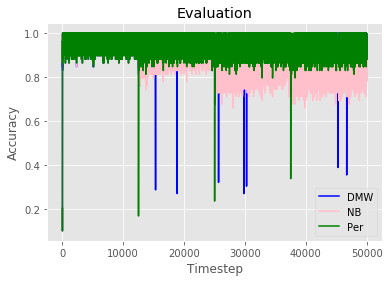

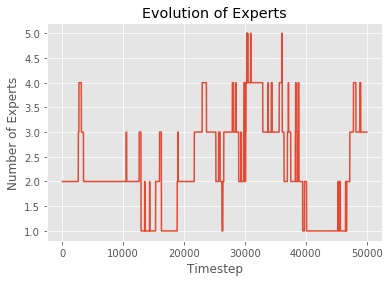

In [46]:
AvrDMW = np.asarray(AvrDMW)
AvrNoE = np.asarray(AvrNoE)
AvrNB = np.asarray(AvrNB)
AvrPF = np.asarray(AvrPF)


AccuDMW = np.zeros((50000))
NoEu = np.zeros((50000))
AccuNB = np.zeros((50000))
AccuPF = np.zeros((50000))

for i in range(AccuDMW.shape[0]):
  AccuDMW[i] = np.mean(AvrDMW[:,i])
  NoEu[i] = np.mean(AvrNoE[:,i])
  AccuNB[i] = np.mean(AvrNB[:,i])
  AccuPF[i] = np.mean(AvrPF[:,i])

plt.style.use("ggplot")
plt.figure(0)
plt.plot(np.arange(0, len(AccuDMW)), AccuDMW,label="DMW",color = "blue")
plt.plot(np.arange(0, len(AccuDMW)), AccuNB,label="NB",color = "pink")
plt.plot(np.arange(0, len(AccuDMW)), AccuPF,label="Per",color = "green")
plt.ylabel('Accuracy')
plt.xlabel("Timestep")
plt.title('Evaluation')
#plt.ylim(0.8,1)

plt.legend()
plt.figure(1)
plt.plot(np.arange(0, len(NoEu)), NoEu,label="Learners")
plt.ylabel('Number of Experts')
plt.xlabel("Timestep")
plt.title('Evolution of Experts')
plt.show

## Dummy tests and tryouts from here.....

In [70]:
def DMW():
  
  #Initialization
  
  
  c = [0,1]
  b = 0.5
  th = 0.01
  p = 1
  
  accDMW = []
  NoE = []
  accNB = []
  accPer = []
  
  Experts = []
  Weights = []
  
  # Initializing experts
  Experts.append(BernoulliNB())
  Weights.append(1)
  NB = BernoulliNB()
  Perfect = BernoulliNB()
  
  Experts[0].partial_fit([np.random.choice(2,9)],[np.random.choice(2,1)],c)
  NB.partial_fit([np.random.choice(2,9)],[np.random.choice(2,1)],c)
  Perfect.partial_fit([np.random.choice(2,9)],[np.random.choice(2,1)],c)
  
  # Starting for stagger
  
  
  for i in tnrange(range(120)):
    
    # Snapshot of dataset
    features , labels = staggerconcept(120,100,i)
    
    # Split the dataset to training and testing:
    train,test = features[0],features[1:]
    train_label,test_labels = labels[0], labels[1:]
    # Update Perfect forgetting
    if i == 40 or i == 80:
      Perfect = BernoulliNB()
      Perfect.partial_fit([np.random.choice(2,9)],[np.random.choice(2,1)],c)
    
    print("Timestep: {}".format(i))
    print("Train vector: {}".format(train))
    print()
    print("With label: {}".format(train_label))
    
    
    # DMW
    s = np.zeros(2)
    for j,e in enumerate(Experts):
      
      temp = int(e.predict([train]))
      
      if temp != train_label:
        Weights[j] *= b
      s[temp] = s[temp]+ Weights[j]
    print("Printing s before doing the prediction:{}".format(s))
    predictionDMW = np.argmax(s)
    print("DMW prediction = {}".format(predictionDMW))
    
    
    # Evaluate DMW for the rest of the dataset
    
    
    print("All the labels: {}".format(test_labels))
    overalPred = np.zeros(len(test_labels))
    predictions = np.zeros((len(test_labels),2))

    for j,e in enumerate(Experts): 
      
      for f in range(len(test)):
        
        t = int(e.predict([test[f]]))
        predictions[f,t] += Weights[j]
        
    for f in range(len(overalPred)):
      overalPred[f] = np.argmax(predictions[f,:])
      
    print("Predictions: {}".format(overalPred))
    accDMW.append(metrics.accuracy_score(test_labels, overalPred))  
    print("With Accuracy for DMW: {}".format(metrics.accuracy_score(test_labels, overalPred)))
    
    #Evaluate for Naive Bayes and PerfectForgettting
    
    
    overalPredNB = np.zeros(len(test_labels))
    overalPredPF = np.zeros(len(test_labels))
    for j,f in enumerate(test):
      overalPredNB[j] = int(NB.predict([f]))
      overalPredPF[j] = int(Perfect.predict([f]))
    accNB.append(metrics.accuracy_score(test_labels, overalPredNB))  
    accPer.append(metrics.accuracy_score(test_labels, overalPredPF))    
    print("With Accuracy for NB: {}".format(metrics.accuracy_score(test_labels, overalPredNB)))
    print("With Accuracy for PF: {}".format(metrics.accuracy_score(test_labels, overalPredPF)))
    
    # Update DMW experts
    
    
    if i % p == 0 :
      
      print("Weights before Normalization: {}".format(Weights))
      Weights = normalize(Weights)
      print("Weights after Normalization: {}".format(Weights))
      
      Experts,Weights = remove_experts(Experts,Weights,th)
      
      if predictionDMW != train_label:
        print("Adding new expert....")
        Experts.append(BernoulliNB())
        Weights.append(1)
    NoE.append(len(Experts))
    
    # Train for the given feature
    for j,expert in enumerate(Experts):
      expert.partial_fit([train],[train_label],c)
    NB.partial_fit([train],[train_label],c)
    Perfect.partial_fit([train],[train_label],c)
    
  return accDMW,NoE,accNB,accPer
    
    

Timestep: 0
Train vector: [1. 0. 0. 0. 1. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.5 0. ]
DMW prediction = 0
All the labels: [1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
With Accuracy for DMW: 0.10101010101010101
With Accuracy for NB: 0.898989898989899
With Accuracy for PF: 0.898989898989899
Weights before Normalization: [0.5]
Weights after Normalization: [1.0]
Adding new expert....
Timestep:

DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
With Accuracy for DMW: 0.9393939393939394
With Accuracy for NB: 1.0
With Accuracy for PF: 0.9797979797979798
Weights before Normalization: [0.5, 1.0, 0.25, 0.125]
Weights after Normalization: [0.5, 1.0, 0.25, 0.125]
Timestep: 12
Train vector: [0. 0. 1. 0. 1. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.    1.875]
DMW 

With Accuracy for DMW: 0.9696969696969697
With Accuracy for NB: 1.0
With Accuracy for PF: 1.0
Weights before Normalization: [0.5, 1.0, 0.125, 0.03125]
Weights after Normalization: [0.5, 1.0, 0.125, 0.03125]
Timestep: 21
Train vector: [1. 0. 0. 1. 0. 0. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0.      1.65625]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1.]
With Accu

Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 1.0
With Accuracy for PF: 1.0
Weights before Normalization: [0.5, 1.0, 0.125, 0.03125]
Weights after Normalization: [0.5, 1.0, 0.125, 0.03125]
Timestep: 31
Train vector: [0. 0. 1. 0. 0. 1. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.      1.65625]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1.]
Predictions: [1. 1. 1. 1

Predictions: [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0.]
With Accuracy for DMW: 0.3434343434343434
With Accuracy for NB: 0.3434343434343434
With Accuracy for PF: 0.3939393939393939
Weights before Normalization: [0.25, 0.5, 0.0625, 0.015625]
Weights after Normalization: [0.5, 1.0, 0.125, 0.03125]
Adding new expert....
Timestep: 41
Train vector: [0. 0. 1. 0. 1. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[1.328125 0.      ]
DMW prediction = 0
All the labels: [1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.

Predictions: [1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 1.]
With Accuracy for DMW: 0.797979797979798
With Accuracy for NB: 0.4444444444444444
With Accuracy for PF: 0.7575757575757576
Weights before Normalization: [0.125, 0.125, 0.03125, 0.5, 0.25, 0.25, 0.0625]
Weights after Normalization: [0.25, 0.25, 0.0625, 1.0, 0.5, 0.5, 0.125]
Adding new expert....
Timestep: 51
Train vector: [0. 1. 0. 1. 0. 0. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[3.125   0.28125]
DMW prediction = 0
All the labels: [1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0.
 1. 

With Accuracy for DMW: 0.7575757575757576
With Accuracy for NB: 0.6060606060606061
With Accuracy for PF: 0.6868686868686869
Weights before Normalization: [1.0, 1.0, 0.125, 0.25]
Weights after Normalization: [1.0, 1.0, 0.125, 0.25]
Timestep: 60
Train vector: [0. 0. 1. 0. 0. 1. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.125 2.125]
DMW prediction = 1
All the labels: [1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 0.]
Predictions: [1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


Timestep: 68
Train vector: [0. 0. 1. 1. 0. 0. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[3.375 0.   ]
DMW prediction = 0
All the labels: [1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0.]
Predictions: [1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0.]
With Accuracy for DMW: 0.8888888888888888
With Accuracy for NB: 0.5656565656565656
With Accuracy for PF: 0.8282828282828283
Weights before Normalization: [1.0, 1.0, 0.25, 0.125, 0.5, 0.5]
Weights after Normalization: [1.

With Accuracy for NB: 0.6666666666666666
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 1.0, 0.25, 0.125, 0.25, 0.25, 1.0]
Weights after Normalization: [1.0, 1.0, 0.25, 0.125, 0.25, 0.25, 1.0]
Timestep: 78
Train vector: [0. 0. 1. 1. 0. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[2.875 0.5  ]
DMW prediction = 0
All the labels: [0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0.
 1. 0. 0.]
Predictions: [0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0.
 1. 0. 0.]
With Accurac

Predictions: [1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.5353535353535354
With Accuracy for NB: 0.43434343434343436
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 1.0, 0.25, 0.125, 0.0625, 0.03125, 0.03125, 0.5, 0.5, 1]
Weights after Normalization: [1.0, 1.0, 0.25, 0.125, 0.0625, 0.03125, 0.03125, 0.5, 0.5, 1.0]
Timestep: 87
Train vector: [0. 0. 1. 0. 0. 1. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.  4.5]
DMW prediction = 1
All the labels: [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 0

Predictions: [1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1.
 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 0. 1.]
With Accuracy for DMW: 0.8080808080808081
With Accuracy for NB: 0.494949494949495
With Accuracy for PF: 1.0
Weights before Normalization: [0.5, 0.5, 0.125, 0.0625, 0.03125, 0.03125, 0.03125, 1.0, 1.0, 1.0]
Weights after Normalization: [0.5, 0.5, 0.125, 0.0625, 0.03125, 0.03125, 0.03125, 1.0, 1.0, 1.0]
Timestep: 95
Train vector: [0. 0. 1. 1. 0. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.609375 3.0625  ]
DMW prediction = 1
All the labels: [0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0

Timestep: 103
Train vector: [1. 0. 0. 0. 1. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[2.109375 0.      ]
DMW prediction = 0
All the labels: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 1. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 1. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.5959595959595959
With Accuracy for PF: 1.0
Weights before Normalization: [0.0625, 0.03125, 0.015625, 1.0, 1.0]
Weights after Normalization: [0.0625, 0.03125, 0.01

With Accuracy for NB: 0.5252525252525253
With Accuracy for PF: 1.0
Weights before Normalization: [0.03125, 0.015625, 1.0, 1.0]
Weights after Normalization: [0.03125, 0.015625, 1.0, 1.0]
Timestep: 112
Train vector: [0. 1. 0. 0. 1. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[2.046875 0.      ]
DMW prediction = 0
All the labels: [0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0.]
Predictions: [0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0.]
With Accuracy for DMW: 1.0


<function matplotlib.pyplot.show(*args, **kw)>

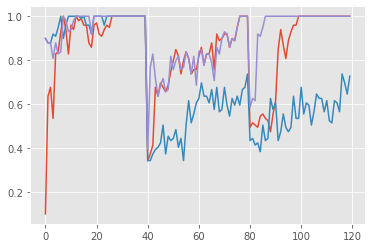

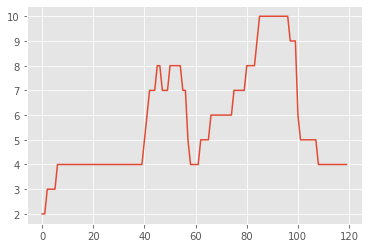

In [140]:
acc,NoE,accNB,accPer = DMW()
plt.style.use("ggplot")
plt.figure(0)
plt.plot(np.arange(0, len(acc)), acc,label="acc")
plt.plot(np.arange(0, len(acc)), accNB,label="acc")
plt.plot(np.arange(0, len(acc)), accPer,label="acc")
plt.figure(1)
plt.plot(np.arange(0, len(NoE)), NoE,label="acc")
plt.show

In [142]:
AvrDMW =[]
AvrNoE = []
AvrNB = []
AvrPF = []

for z in tqdm(range(10)):
  acc,NoE,accNB,accPer = DMW()
  AvrDMW.append(acc)
  AvrNoE.append(NoE)
  AvrNB.append(accNB)
  AvrPF.append(accPer)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Timestep: 0
Train vector: [0. 0. 1. 0. 1. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[1. 0.]
DMW prediction = 0
All the labels: [1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 1.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
With Accuracy for DMW: 0.1717171717171717
With Accuracy for NB: 0.8282828282828283
With Accuracy for PF: 0.8282828282828283
Weights before Normalization: [1]
Weights after Normalization: [1.0]
Timestep: 1
Train vector: [0. 1. 0

With Accuracy for NB: 0.8686868686868687
With Accuracy for PF: 0.8383838383838383
Weights before Normalization: [1.0, 1.0]
Weights after Normalization: [1.0, 1.0]
Timestep: 9
Train vector: [1. 0. 0. 0. 1. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.5 1. ]
DMW prediction = 1
All the labels: [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1.]
Predictions: [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.8686868686868687
With Accuracy for NB

With Accuracy for NB: 1.0
With Accuracy for PF: 0.9696969696969697
Weights before Normalization: [1.0, 1.0, 1]
Weights after Normalization: [1.0, 1.0, 1.0]
Timestep: 18
Train vector: [1. 0. 0. 1. 0. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.5 2. ]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.9494949494949495
With Accuracy for NB: 1.0


Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 1.0
With Accuracy for PF: 1.0
Weights before Normalization: [0.5, 1.0, 1.0, 0.125]
Weights after Normalization: [0.5, 1.0, 1.0, 0.125]
Timestep: 28
Train vector: [1. 0. 0. 1. 0. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.    2.625]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 0. 1. 1

With Accuracy for NB: 1.0
With Accuracy for PF: 1.0
Weights before Normalization: [0.5, 1.0, 0.5, 0.0625]
Weights after Normalization: [0.5, 1.0, 0.5, 0.0625]
Timestep: 37
Train vector: [0. 1. 0. 0. 0. 1. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.     2.0625]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 1.0
With A

With Accuracy for NB: 0.45454545454545453
With Accuracy for PF: 0.6666666666666666
Weights before Normalization: [0.25, 0.5, 0.25, 0.03125, 1]
Weights after Normalization: [0.25, 0.5, 0.25, 0.03125, 1.0]
Adding new expert....
Timestep: 46
Train vector: [0. 1. 0. 1. 0. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[2.       0.515625]
DMW prediction = 0
All the labels: [0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.
 1. 0. 1.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Predictions: [1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0.
 0. 0. 0.]
With Accuracy for DMW: 0.9696969696969697
With Accuracy for NB: 0.494949494949495
With Accuracy for PF: 0.9696969696969697
Weights before Normalization: [0.0078125, 0.015625, 0.03125, 0.25, 0.25, 1.0, 0.5]
Weights after Normalization: [0.0078125, 0.015625, 0.03125, 0.25, 0.25, 1.0, 0.5]
Timestep: 55
Train vector: [0. 1. 0. 0. 0. 1. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.25     1.546875]
DMW prediction = 1
All the labels: [1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1.
 1. 0. 1. 

Timestep: 63
Train vector: [1. 0. 0. 1. 0. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[0.25 0.75]
DMW prediction = 1
All the labels: [0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0.
 1. 1. 0.]
Predictions: [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 0.]
With Accuracy for DMW: 0.8484848484848485
With Accuracy for NB: 0.5555555555555556
With Accuracy for PF: 1.0
Weights before Normalization: [0.25, 0.125, 0.5, 0.125]
Weights after Normalization: [0.5, 0.25, 1.0, 0.25]
Addin

Predictions: [1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.6767676767676768
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.5, 1.0, 0.5, 0.25]
Weights after Normalization: [1.0, 0.5, 1.0, 0.5, 0.25]
Timestep: 72
Train vector: [0. 1. 0. 1. 0. 0. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[3.25 0.  ]
DMW prediction = 0
All the labels: [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1.
 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0.]
Predictions: [0

Predictions: [0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 1.]
With Accuracy for DMW: 0.5757575757575758
With Accuracy for NB: 0.3333333333333333
With Accuracy for PF: 0.7272727272727273
Weights before Normalization: [0.5, 0.25, 0.5, 0.25, 0.0625]
Weights after Normalization: [1.0, 0.5, 1.0, 0.5, 0.125]
Adding new expert....
Timestep: 81
Train vector: [0. 1. 0. 0. 1. 0. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[0.     2.0625]
DMW prediction = 1
All the labels: [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0

With Accuracy for PF: 0.8686868686868687
Weights before Normalization: [0.25, 0.125, 0.25, 0.125, 0.0625, 0.5, 0.5, 0.5]
Weights after Normalization: [0.5, 0.25, 0.5, 0.25, 0.125, 1.0, 1.0, 1.0]
Timestep: 90
Train vector: [1. 0. 0. 1. 0. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[4.625 0.   ]
DMW prediction = 0
All the labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0.]
With Accuracy for DMW: 0.

 1. 0. 1.]
Predictions: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 1.]
With Accuracy for DMW: 0.9393939393939394
With Accuracy for NB: 0.494949494949495
With Accuracy for PF: 1.0
Weights before Normalization: [0.125, 0.0625, 0.125, 0.0625, 0.0625, 1.0, 1.0, 0.5]
Weights after Normalization: [0.125, 0.0625, 0.125, 0.0625, 0.0625, 1.0, 1.0, 0.5]
Timestep: 99
Train vector: [1. 0. 0. 1. 0. 0. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[2.9375 0.    ]
DMW prediction = 0
All the labels: [1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 

Timestep: 107
Train vector: [0. 0. 1. 0. 0. 1. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0.    2.625]
DMW prediction = 1
All the labels: [1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0.]
Predictions: [1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0.]
With Accuracy for DMW: 0.9797979797979798
With Accuracy for NB: 0.5454545454545454
With Accuracy for PF: 1.0
Weights before Normalization: [0.03125, 0.015625, 0.03125, 0.015625, 0.03125, 1.0, 1.0, 0.5]
Weights after Nor

Timestep: 115
Train vector: [0. 0. 1. 1. 0. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.  1.5]
DMW prediction = 1
All the labels: [0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 0.]
Predictions: [0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.5757575757575758
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.5]
Weights after Normalization: [1.0, 0.5]
Timestep: 116
Train vector: [0. 1. 0. 1. 0. 0. 1

 10%|████████▎                                                                          | 1/10 [00:08<01:16,  8.51s/it]

Predictions: [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.6363636363636364
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.5]
Weights after Normalization: [1.0, 0.5]
Timestep: 0
Train vector: [0. 1. 0. 1. 0. 0. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0. 1.]
DMW prediction = 1
All the labels: [1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

Predictions: [1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.6464646464646465
With Accuracy for NB: 0.6262626262626263
With Accuracy for PF: 0.6767676767676768
Weights before Normalization: [1.0, 0.5]
Weights after Normalization: [1.0, 0.5]
Timestep: 10
Train vector: [0. 1. 0. 0. 0. 1. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0.  1.5]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
Predictions: [0. 1.

With Accuracy for PF: 0.8484848484848485
Weights before Normalization: [1.0, 0.25]
Weights after Normalization: [1.0, 0.25]
Timestep: 18
Train vector: [1. 0. 0. 0. 0. 1. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0.   1.25]
DMW prediction = 1
All the labels: [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.8484848484848485
With Accuracy for NB: 0.7777777777777778
With Accuracy f

Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 1.]
With Accuracy for DMW: 0.9191919191919192
With Accuracy for NB: 0.797979797979798
With Accuracy for PF: 0.9191919191919192
Weights before Normalization: [1.0, 0.25, 0.5]
Weights after Normalization: [1.0, 0.25, 0.5]
Timestep: 27
Train vector: [0. 0. 1. 0. 1. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[1.75 0.  ]
DMW prediction = 0
All the labels: [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
Predic

Timestep: 38
Train vector: [0. 0. 1. 1. 0. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.    2.375]
DMW prediction = 1
All the labels: [1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.8686868686868687
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.25, 0.125, 1.0]
Weights after Normalization: [1.0, 0.25, 0.125, 1.0]
Timestep: 39
Train 

Predictions: [0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 1. 1.]
With Accuracy for DMW: 0.6666666666666666
With Accuracy for NB: 0.32323232323232326
With Accuracy for PF: 0.6363636363636364
Weights before Normalization: [0.25, 0.0625, 0.03125, 0.5, 1.0, 1.0, 0.5]
Weights after Normalization: [0.25, 0.0625, 0.03125, 0.5, 1.0, 1.0, 0.5]
Timestep: 47
Train vector: [0. 0. 1. 1. 0. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[3.34375 0.     ]
DMW prediction = 0
All the labels: [0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 

Predictions: [0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
With Accuracy for DMW: 0.7070707070707071
With Accuracy for NB: 0.5757575757575758
With Accuracy for PF: 0.696969696969697
Weights before Normalization: [0.015625, 1.0, 1.0, 0.125, 0.25, 0.5]
Weights after Normalization: [0.015625, 1.0, 1.0, 0.125, 0.25, 0.5]
Timestep: 57
Train vector: [0. 0. 1. 0. 1. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[1.3203125 0.25     ]
DMW prediction = 0
All the labels: [1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0.

Timestep: 67
Train vector: [1. 0. 0. 0. 0. 1. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0. 3.]
DMW prediction = 1
All the labels: [0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 1.]
Predictions: [0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.6161616161616161
With Accuracy for PF: 0.9696969696969697
Weights before Normalization: [1.0, 1.0, 0.125, 0.5, 0.25, 0.125]
Weights after Normalization: [1.0, 1.0, 0.125, 0.5,

 1. 0. 0.]
Predictions: [0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 0.]
With Accuracy for DMW: 0.9494949494949495
With Accuracy for NB: 0.7373737373737373
With Accuracy for PF: 0.9494949494949495
Weights before Normalization: [1.0, 1.0, 0.125, 0.25, 0.0625, 0.03125]
Weights after Normalization: [1.0, 1.0, 0.125, 0.25, 0.0625, 0.03125]
Timestep: 76
Train vector: [0. 0. 1. 0. 1. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.      2.46875]
DMW prediction = 1
All the labels: [1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0.

Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0.]
With Accuracy for DMW: 0.7575757575757576
With Accuracy for NB: 0.30303030303030304
With Accuracy for PF: 0.7878787878787878
Weights before Normalization: [1.0, 1.0, 0.125, 0.25, 0.0625, 0.03125, 1.0, 1.0, 1]
Weights after Normalization: [1.0, 1.0, 0.125, 0.25, 0.0625, 0.03125, 1.0, 1.0, 1.0]
Timestep: 85
Train vector: [0. 0. 1. 0. 1. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.5     4.46875]
DMW prediction = 1
All the labels: [0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0.

Predictions: [1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0.]
With Accuracy for DMW: 0.9494949494949495
With Accuracy for NB: 0.40404040404040403
With Accuracy for PF: 1.0
Weights before Normalization: [0.0625, 0.0625, 0.015625, 1.0, 1.0, 0.5, 1.0]
Weights after Normalization: [0.0625, 0.0625, 0.015625, 1.0, 1.0, 0.5, 1.0]
Timestep: 94
Train vector: [1. 0. 0. 0. 0. 1. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[3.5       0.0703125]
DMW prediction = 0
All the labels: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.

Predictions: [0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.6161616161616161
With Accuracy for PF: 1.0
Weights before Normalization: [0.0078125, 1.0, 0.5, 0.5, 1.0]
Weights after Normalization: [0.0078125, 1.0, 0.5, 0.5, 1.0]
Timestep: 104
Train vector: [0. 1. 0. 0. 1. 0. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[3. 0.]
DMW prediction = 0
All the labels: [0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1.
 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 0.]
Predicti

With Accuracy for NB: 0.494949494949495
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.5, 0.5, 0.25]
Weights after Normalization: [1.0, 0.5, 0.5, 0.25]
Timestep: 113
Train vector: [1. 0. 0. 1. 0. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[2.25 0.  ]
DMW prediction = 0
All the labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.5

 20%|████████████████▌                                                                  | 2/10 [00:16<01:07,  8.46s/it]

With Accuracy for NB: 0.494949494949495
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.5, 0.5, 0.25]
Weights after Normalization: [1.0, 0.5, 0.5, 0.25]
Timestep: 119
Train vector: [0. 0. 1. 0. 1. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.   2.25]
DMW prediction = 1
All the labels: [1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 0. 1. 1.]
Predictions: [1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 0. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.6

With Accuracy for PF: 0.8888888888888888
Weights before Normalization: [1.0]
Weights after Normalization: [1.0]
Timestep: 9
Train vector: [1. 0. 0. 1. 0. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0. 1.]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.8686868686868687
With Accuracy for NB: 0.8686868686868687
With Accuracy for PF: 0.86868686

With Accuracy for DMW: 0.9191919191919192
With Accuracy for NB: 0.9191919191919192
With Accuracy for PF: 0.8585858585858586
Weights before Normalization: [1.0, 0.5, 1.0]
Weights after Normalization: [1.0, 0.5, 1.0]
Timestep: 18
Train vector: [0. 0. 1. 0. 0. 1. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.25 2.  ]
DMW prediction = 1
All the labels: [1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1.]
Predictions: [1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Ac

Predictions: [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 1.0
With Accuracy for PF: 0.8181818181818182
Weights before Normalization: [1.0, 0.125, 0.5, 0.25]
Weights after Normalization: [1.0, 0.125, 0.5, 0.25]
Timestep: 28
Train vector: [0. 0. 1. 1. 0. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[1.875 0.   ]
DMW prediction = 0
All the labels: [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0.]
Predictions: [1. 1.

DMW prediction = 1
All the labels: [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 1.0
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.125, 0.5, 0.25]
Weights after Normalization: [1.0, 0.125, 0.5, 0.25]
Timestep: 38
Train vector: [0. 0. 1. 0. 0. 1. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.    1.875]
DMW prediction = 1
All the labels:

Predictions: [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.5353535353535354
With Accuracy for NB: 0.46464646464646464
With Accuracy for PF: 0.7272727272727273
Weights before Normalization: [0.5, 0.0625, 0.25, 0.25, 0.5]
Weights after Normalization: [1.0, 0.125, 0.5, 0.5, 1.0]
Adding new expert....
Timestep: 47
Train vector: [0. 1. 0. 0. 0. 1. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[1.     1.5625]
DMW prediction = 1
All the labels: [0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 

Predictions: [0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 1. 1.]
With Accuracy for DMW: 0.7575757575757576
With Accuracy for NB: 0.42424242424242425
With Accuracy for PF: 0.8787878787878788
Weights before Normalization: [0.125, 0.015625, 0.0625, 0.0625, 0.5, 0.5, 0.25, 0.5, 0.5]
Weights after Normalization: [0.25, 0.03125, 0.125, 0.125, 1.0, 1.0, 0.5, 1.0, 1.0]
Timestep: 56
Train vector: [1. 0. 0. 1. 0. 0. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[4.625    0.203125]
DMW prediction = 0
All the labels: [0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0.

Timestep: 64
Train vector: [1. 0. 0. 0. 0. 1. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[2.0078125 0.       ]
DMW prediction = 0
All the labels: [1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 0.]
Predictions: [1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1.
 0. 1. 0.]
With Accuracy for DMW: 0.8888888888888888
With Accuracy for NB: 0.6161616161616161
With Accuracy for PF: 1.0
Weights before Normalization: [0.0078125, 1.0, 0.25, 0.25, 0.5]
Weights after Normalization: [0.0078125

Predictions: [1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0.]
With Accuracy for DMW: 0.9191919191919192
With Accuracy for NB: 0.7070707070707071
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.25, 0.25, 0.5, 0.5]
Weights after Normalization: [1.0, 0.25, 0.25, 0.5, 0.5]
Timestep: 74
Train vector: [0. 1. 0. 1. 0. 0. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[2.   0.25]
DMW prediction = 0
All the labels: [1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 0. 0. 1.

Predictions: [0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0.]
With Accuracy for DMW: 0.6868686868686869
With Accuracy for NB: 0.30303030303030304
With Accuracy for PF: 0.7171717171717171
Weights before Normalization: [0.5, 0.125, 0.125, 0.125, 0.125, 0.25, 1.0]
Weights after Normalization: [0.5, 0.125, 0.125, 0.125, 0.125, 0.25, 1.0]
Timestep: 83
Train vector: [0. 1. 0. 0. 1. 0. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[1.375  0.4375]
DMW prediction = 0
All the labels: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 

Predictions: [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0.]
With Accuracy for DMW: 0.8282828282828283
With Accuracy for NB: 0.40404040404040403
With Accuracy for PF: 0.7171717171717171
Weights before Normalization: [0.015625, 0.03125, 1.0, 0.5]
Weights after Normalization: [0.015625, 0.03125, 1.0, 0.5]
Timestep: 91
Train vector: [0. 1. 0. 0. 1. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[1.53125   0.0078125]
DMW prediction = 0
All the labels: [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 

With Accuracy for NB: 0.41414141414141414
With Accuracy for PF: 1.0
Weights before Normalization: [0.015625, 1.0, 0.5, 0.25]
Weights after Normalization: [0.015625, 1.0, 0.5, 0.25]
Timestep: 101
Train vector: [1. 0. 0. 0. 1. 0. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[1.765625 0.      ]
DMW prediction = 0
All the labels: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
With Accuracy for DMW: 1.0
With 

With Accuracy for NB: 0.5757575757575758
With Accuracy for PF: 1.0
Weights before Normalization: [0.015625, 1.0, 0.5, 0.125]
Weights after Normalization: [0.015625, 1.0, 0.5, 0.125]
Timestep: 110
Train vector: [0. 1. 0. 1. 0. 0. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[1.640625 0.      ]
DMW prediction = 0
All the labels: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0.]
Predictions: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0.]
With Accuracy for DMW: 1.0
With

 30%|████████████████████████▉                                                          | 3/10 [00:24<00:58,  8.32s/it]

Predictions: [1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.5454545454545454
With Accuracy for PF: 1.0
Weights before Normalization: [0.015625, 1.0, 0.5, 0.125]
Weights after Normalization: [0.015625, 1.0, 0.5, 0.125]
Timestep: 0
Train vector: [1. 0. 0. 0. 1. 0. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0. 1.]
DMW prediction = 1
All the labels: [1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1.]
Predictions: [1. 1

With Accuracy for DMW: 1.0
With Accuracy for NB: 0.898989898989899
With Accuracy for PF: 0.898989898989899
Weights before Normalization: [1.0, 0.25, 1.0]
Weights after Normalization: [1.0, 0.25, 1.0]
Timestep: 9
Train vector: [1. 0. 0. 1. 0. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.   2.25]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 0.]
Predictions: [1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 0.]
With Accuracy for DMW: 

Timestep: 20
Train vector: [0. 0. 1. 0. 0. 1. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[1.    0.375]
DMW prediction = 0
All the labels: [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1.
 1. 1. 1.]
Predictions: [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 1.0
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.125, 0.25]
Weights after Normalization: [1.0, 0.125, 0.25]
Timestep: 21
Train vector: [1. 0. 0. 1. 0. 0

Timestep: 31
Train vector: [1. 0. 0. 1. 0. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.    1.375]
DMW prediction = 1
All the labels: [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 1.0
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.125, 0.25]
Weights after Normalization: [1.0, 0.125, 0.25]
Timestep: 32
Train vector: [1. 0. 0. 0. 0. 1

Timestep: 42
Train vector: [0. 0. 1. 0. 1. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[1.1875 0.    ]
DMW prediction = 0
All the labels: [1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1.
 0. 0. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 0.]
With Accuracy for DMW: 0.41414141414141414
With Accuracy for NB: 0.41414141414141414
With Accuracy for PF: 0.5757575757575758
Weights before Normalization: [0.5, 0.0625, 0.125, 0.5]
Weights after Normalization: [1.0, 0

Predictions: [1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
With Accuracy for DMW: 0.696969696969697
With Accuracy for NB: 0.3939393939393939
With Accuracy for PF: 0.7676767676767676
Weights before Normalization: [0.5, 0.0625, 0.125, 0.125, 1.0, 0.125]
Weights after Normalization: [0.5, 0.0625, 0.125, 0.125, 1.0, 0.125]
Timestep: 51
Train vector: [0. 0. 1. 0. 1. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.     1.9375]
DMW prediction = 1
All the labels: [0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 

Predictions: [0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0.
 1. 0. 1.]
With Accuracy for DMW: 0.9292929292929293
With Accuracy for NB: 0.5353535353535354
With Accuracy for PF: 0.797979797979798
Weights before Normalization: [0.0625, 0.015625, 0.125, 1.0, 0.125, 1.0, 0.25]
Weights after Normalization: [0.0625, 0.015625, 0.125, 1.0, 0.125, 1.0, 0.25]
Timestep: 61
Train vector: [0. 1. 0. 0. 1. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.       2.578125]
DMW prediction = 1
All the labels: [1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 1.

Predictions: [0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 0.]
With Accuracy for DMW: 0.8383838383838383
With Accuracy for NB: 0.6767676767676768
With Accuracy for PF: 0.8787878787878788
Weights before Normalization: [0.125, 1.0, 0.125, 0.5, 0.125, 0.25]
Weights after Normalization: [0.125, 1.0, 0.125, 0.5, 0.125, 0.25]
Timestep: 71
Train vector: [0. 1. 0. 0. 0. 1. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.    2.125]
DMW prediction = 1
All the labels: [0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.

Predictions: [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 1.]
With Accuracy for DMW: 0.5757575757575758
With Accuracy for NB: 0.40404040404040403
With Accuracy for PF: 0.7373737373737373
Weights before Normalization: [0.125, 0.5, 0.03125, 1.0, 0.125, 0.125, 0.25]
Weights after Normalization: [0.125, 0.5, 0.03125, 1.0, 0.125, 0.125, 0.25]
Timestep: 81
Train vector: [0. 1. 0. 1. 0. 0. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[2.15625 0.     ]
DMW prediction = 0
All the labels: [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 

Predictions: [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1.
 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0.]
With Accuracy for DMW: 0.8383838383838383
With Accuracy for NB: 0.3939393939393939
With Accuracy for PF: 0.7676767676767676
Weights before Normalization: [0.0625, 0.25, 0.015625, 0.5, 0.0625, 0.0625, 0.125, 1.0, 0.5, 0.5]
Weights after Normalization: [0.0625, 0.25, 0.015625, 0.5, 0.0625, 0.0625, 0.125, 1.0, 0.5, 0.5]
Adding new expert....
Timestep: 89
Train vector: [0. 0. 1. 1. 0. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.       4.078125]
DMW prediction = 1
All the labels: [0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.

With Accuracy for DMW: 0.8080808080808081
With Accuracy for NB: 0.45454545454545453
With Accuracy for PF: 0.8585858585858586
Weights before Normalization: [0.015625, 0.0625, 0.0078125, 0.015625, 0.03125, 1.0, 0.5, 0.25, 0.5]
Weights after Normalization: [0.015625, 0.0625, 0.0078125, 0.015625, 0.03125, 1.0, 0.5, 0.25, 0.5]
Timestep: 97
Train vector: [0. 0. 1. 1. 0. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.    2.375]
DMW prediction = 1
All the labels: [0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 1.]
Predictions: [0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1

With Accuracy for DMW: 1.0
With Accuracy for NB: 0.6565656565656566
With Accuracy for PF: 1.0
Weights before Normalization: [0.0625, 0.03125, 0.0625, 1.0, 0.25, 0.125, 0.25, 0.25]
Weights after Normalization: [0.0625, 0.03125, 0.0625, 1.0, 0.25, 0.125, 0.25, 0.25]
Timestep: 106
Train vector: [0. 1. 0. 0. 1. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[2.03125 0.     ]
DMW prediction = 0
All the labels: [1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 1. 1.]
Predictions: [1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 

With Accuracy for DMW: 1.0
With Accuracy for NB: 0.6666666666666666
With Accuracy for PF: 1.0
Weights before Normalization: [0.0625, 0.03125, 0.0625, 1.0, 0.25, 0.125, 0.125, 0.0625]
Weights after Normalization: [0.0625, 0.03125, 0.0625, 1.0, 0.25, 0.125, 0.125, 0.0625]
Timestep: 115
Train vector: [0. 1. 0. 0. 0. 1. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[1.71875 0.     ]
DMW prediction = 0
All the labels: [0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 1. 0. 1.]
Predictions: [0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 

 40%|█████████████████████████████████▏                                                 | 4/10 [00:34<00:51,  8.63s/it]

With Accuracy for PF: 1.0
Weights before Normalization: [0.0625, 0.03125, 0.0625, 1.0, 0.25, 0.125, 0.125, 0.0625]
Weights after Normalization: [0.0625, 0.03125, 0.0625, 1.0, 0.25, 0.125, 0.125, 0.0625]
Timestep: 119
Train vector: [1. 0. 0. 1. 0. 0. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[1.53125 0.09375]
DMW prediction = 0
All the labels: [0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 1.]
Predictions: [0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 1.]
With Accurac

Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.8383838383838383
With Accuracy for NB: 0.8383838383838383
With Accuracy for PF: 0.8383838383838383
Weights before Normalization: [1.0]
Weights after Normalization: [1.0]
Timestep: 8
Train vector: [0. 1. 0. 0. 0. 1. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0. 1.]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 0.]
Predictions: [1. 1. 1. 1. 1. 1. 

Timestep: 17
Train vector: [0. 0. 1. 0. 1. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[0.  0.5]
DMW prediction = 1
All the labels: [1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.8585858585858586
With Accuracy for NB: 0.8585858585858586
With Accuracy for PF: 0.8585858585858586
Weights before Normalization: [0.5]
Weights after Normalization: [1.0]
Adding new expert....
Timeste

Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 1.0
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.125, 0.25]
Weights after Normalization: [1.0, 0.125, 0.25]
Timestep: 26
Train vector: [0. 0. 1. 0. 0. 1. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.125 1.125]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.9393939393939394
With Accuracy for NB: 0.9393939393939394
With Accuracy for PF: 0.9393939393939394
Weights before Normalization: [1.0, 0.125, 0.125]
Weights after Normalization: [1.0, 0.125, 0.125]
Timestep: 37
Train vector: [0. 1. 0. 0. 1. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.   1.25]
DMW prediction = 1
All the labels: [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1.]

Predictions: [0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0.]
With Accuracy for DMW: 0.7575757575757576
With Accuracy for NB: 0.5454545454545454
With Accuracy for PF: 0.7676767676767676
Weights before Normalization: [0.5, 0.0625, 0.0625, 1.0, 0.5]
Weights after Normalization: [0.5, 0.0625, 0.0625, 1.0, 0.5]
Timestep: 47
Train vector: [0. 0. 1. 1. 0. 0. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[1.5625  0.28125]
DMW prediction = 0
All the labels: [0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1

Timestep: 55
Train vector: [1. 0. 0. 0. 0. 1. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.5    2.6875]
DMW prediction = 1
All the labels: [0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0.]
Predictions: [0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
With Accuracy for DMW: 0.8080808080808081
With Accuracy for NB: 0.6060606060606061
With Accuracy for PF: 0.8181818181818182
Weights before Normalization: [0.5, 0.0625, 0.125, 1.0, 1.0, 0.5]
Weights after Normalization:

With Accuracy for NB: 0.7676767676767676
With Accuracy for PF: 0.98989898989899
Weights before Normalization: [0.015625, 1.0, 0.25, 0.125]
Weights after Normalization: [0.015625, 1.0, 0.25, 0.125]
Timestep: 64
Train vector: [1. 0. 0. 0. 0. 1. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.       1.390625]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 0.]
Predictions: [1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 0.]
With Accuracy for

With Accuracy for DMW: 1.0
With Accuracy for NB: 0.7676767676767676
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.25, 0.03125]
Weights after Normalization: [1.0, 0.25, 0.03125]
Timestep: 75
Train vector: [0. 1. 0. 0. 1. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.      1.28125]
DMW prediction = 1
All the labels: [1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0.]
Predictions: [1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0.]
With Accuracy for DMW

Timestep: 86
Train vector: [0. 0. 1. 0. 1. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.5      0.640625]
DMW prediction = 1
All the labels: [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0.]
Predictions: [1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.45454545454545453
With Accuracy for NB: 0.30303030303030304
With Accuracy for PF: 0.7878787878787878
Weights before Normalization: [0.5, 0.125, 0.015625, 0.5]
Weights after Normalization: [

Predictions: [0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.5151515151515151
With Accuracy for PF: 0.9292929292929293
Weights before Normalization: [0.03125, 0.0078125, 1.0, 0.0625]
Weights after Normalization: [0.03125, 0.0078125, 1.0, 0.0625]
Timestep: 96
Train vector: [0. 0. 1. 0. 1. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.      1.09375]
DMW prediction = 1
All the labels: [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 

Predictions: [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.47474747474747475
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.0625]
Weights after Normalization: [1.0, 0.0625]
Timestep: 108
Train vector: [0. 0. 1. 0. 0. 1. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.     1.0625]
DMW prediction = 1
All the labels: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0.]
Predictions: [1. 0. 0. 0. 0. 0. 0. 

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:40<00:40,  8.02s/it]

Predictions: [0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.494949494949495
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.0625]
Weights after Normalization: [1.0, 0.0625]
Timestep: 117
Train vector: [0. 1. 0. 0. 1. 0. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[1.0625 0.    ]
DMW prediction = 0
All the labels: [0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 0. 0.]
Predictions: [0. 1. 0. 1. 0. 0. 1. 0.

Timestep: 5
Train vector: [1. 0. 0. 0. 1. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.   1.25]
DMW prediction = 1
All the labels: [0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.8686868686868687
With Accuracy for NB: 0.8686868686868687
With Accuracy for PF: 0.8686868686868687
Weights before Normalization: [0.25, 1.0]
Weights after Normalization: [0.25, 1.0]
Timestep: 6
Trai

Timestep: 17
Train vector: [0. 0. 1. 0. 0. 1. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[0.   0.75]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.9292929292929293
With Accuracy for NB: 0.9292929292929293
With Accuracy for PF: 0.9292929292929293
Weights before Normalization: [0.125, 0.5, 0.125]
Weights after Normalization: [0.25, 1.0, 0.25]
A

With Accuracy for NB: 1.0
With Accuracy for PF: 1.0
Weights before Normalization: [0.125, 1.0, 0.125, 0.25]
Weights after Normalization: [0.125, 1.0, 0.125, 0.25]
Timestep: 27
Train vector: [0. 0. 1. 0. 1. 0. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0.  1.5]
DMW prediction = 1
All the labels: [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 1.0
With Acc

With Accuracy for NB: 1.0
With Accuracy for PF: 1.0
Weights before Normalization: [0.125, 1.0, 0.125, 0.25]
Weights after Normalization: [0.125, 1.0, 0.125, 0.25]
Timestep: 36
Train vector: [1. 0. 0. 1. 0. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.  1.5]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 1.0
With Acc

Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
With Accuracy for DMW: 0.5858585858585859
With Accuracy for NB: 0.3939393939393939
With Accuracy for PF: 0.7171717171717171
Weights before Normalization: [0.03125, 0.25, 0.03125, 0.0625, 0.5]
Weights after Normalization: [0.0625, 0.5, 0.0625, 0.125, 1.0]
Adding new expert....
Timestep: 45
Train vector: [0. 1. 0. 0. 1. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.   2.75]
DMW prediction = 1
All the labels: [1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0

With Accuracy for DMW: 0.8383838383838383
With Accuracy for NB: 0.5656565656565656
With Accuracy for PF: 0.8383838383838383
Weights before Normalization: [0.03125, 0.25, 0.0625, 0.125, 1.0, 0.5]
Weights after Normalization: [0.03125, 0.25, 0.0625, 0.125, 1.0, 0.5]
Timestep: 53
Train vector: [0. 0. 1. 1. 0. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[1.96875 0.     ]
DMW prediction = 0
All the labels: [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0.
 0. 1. 1.]
Predictions: [1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0

With Accuracy for NB: 0.46464646464646464
With Accuracy for PF: 0.898989898989899
Weights before Normalization: [0.03125, 0.25, 0.0625, 0.125, 1.0, 0.5, 1.0, 0.5, 0.5]
Weights after Normalization: [0.03125, 0.25, 0.0625, 0.125, 1.0, 0.5, 1.0, 0.5, 0.5]
Timestep: 62
Train vector: [0. 1. 0. 1. 0. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[0.       1.984375]
DMW prediction = 1
All the labels: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 0. 0.]
Predictions: [1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.

Predictions: [1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 0. 0.]
With Accuracy for DMW: 0.8888888888888888
With Accuracy for NB: 0.5353535353535354
With Accuracy for PF: 0.9090909090909091
Weights before Normalization: [0.03125, 0.25, 0.0625, 0.125, 1.0, 0.5, 1.0, 0.5, 0.5, 0.25]
Weights after Normalization: [0.03125, 0.25, 0.0625, 0.125, 1.0, 0.5, 1.0, 0.5, 0.5, 0.25]
Timestep: 70
Train vector: [0. 0. 1. 0. 0. 1. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.      4.21875]
DMW prediction = 1
All the labels: [1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0.

Predictions: [1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0.]
With Accuracy for DMW: 0.9292929292929293
With Accuracy for NB: 0.5454545454545454
With Accuracy for PF: 0.898989898989899
Weights before Normalization: [0.03125, 0.015625, 0.03125, 0.5, 1.0, 1.0, 0.25, 0.5, 0.0625, 0.5]
Weights after Normalization: [0.03125, 0.015625, 0.03125, 0.5, 1.0, 1.0, 0.25, 0.5, 0.0625, 0.5]
Timestep: 78
Train vector: [0. 0. 1. 1. 0. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[3.890625 0.      ]
DMW prediction = 0
All the labels: [1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1

With Accuracy for DMW: 0.46464646464646464
With Accuracy for NB: 0.32323232323232326
With Accuracy for PF: 0.898989898989899
Weights before Normalization: [1.0, 1.0, 0.25, 0.5, 0.03125, 0.25, 1.0]
Weights after Normalization: [1.0, 1.0, 0.25, 0.5, 0.03125, 0.25, 1.0]
Timestep: 86
Train vector: [1. 0. 0. 1. 0. 0. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[3.03125 0.5    ]
DMW prediction = 0
All the labels: [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 0.]
Predictions: [1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0

Predictions: [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 1. 0. 0.]
With Accuracy for DMW: 0.696969696969697
With Accuracy for NB: 0.29292929292929293
With Accuracy for PF: 0.898989898989899
Weights before Normalization: [0.25, 0.25, 0.125, 0.25, 0.015625, 0.125, 1.0, 1.0, 1.0]
Weights after Normalization: [0.25, 0.25, 0.125, 0.25, 0.015625, 0.125, 1.0, 1.0, 1.0]
Timestep: 95
Train vector: [0. 0. 1. 0. 1. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.       4.015625]
DMW prediction = 1
All the labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0.


Timestep: 103
Train vector: [1. 0. 0. 0. 1. 0. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[4.078125 0.      ]
DMW prediction = 0
All the labels: [0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 1.]
Predictions: [0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.3434343434343434
With Accuracy for PF: 1.0
Weights before Normalization: [0.015625, 0.015625, 0.015625, 0.03125, 1.0, 1.0, 1.0, 1]
Weights after Normalization: [0

With Accuracy for NB: 0.6363636363636364
With Accuracy for PF: 1.0
Weights before Normalization: [0.015625, 1.0, 1.0, 0.25]
Weights after Normalization: [0.015625, 1.0, 1.0, 0.25]
Timestep: 114
Train vector: [0. 0. 1. 0. 0. 1. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0.125    2.015625]
DMW prediction = 1
All the labels: [0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.
 0. 1. 0.]
Predictions: [0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.
 0. 1. 0.]
With Accuracy for DMW: 1.0
With A

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:50<00:34,  8.53s/it]

With Accuracy for PF: 1.0
Weights before Normalization: [0.015625, 1.0, 1.0, 0.125]
Weights after Normalization: [0.015625, 1.0, 1.0, 0.125]
Timestep: 0
Train vector: [0. 1. 0. 1. 0. 0. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0. 1.]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.8686868686868687
With Accuracy for NB: 0.13131313131313133
Wi

With Accuracy for NB: 0.8383838383838383
With Accuracy for PF: 0.8282828282828283
Weights before Normalization: [1.0, 0.5, 1.0]
Weights after Normalization: [1.0, 0.5, 1.0]
Timestep: 12
Train vector: [0. 0. 1. 0. 1. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[1.5 0.5]
DMW prediction = 0
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.98989898989899
With Accura

Predictions: [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.9494949494949495
With Accuracy for PF: 0.9696969696969697
Weights before Normalization: [1.0, 0.5, 0.25]
Weights after Normalization: [1.0, 0.5, 0.25]
Timestep: 24
Train vector: [0. 0. 1. 0. 0. 1. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[1.75 0.  ]
DMW prediction = 0
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 

With Accuracy for NB: 0.9292929292929293
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.5, 0.25]
Weights after Normalization: [1.0, 0.5, 0.25]
Timestep: 34
Train vector: [0. 1. 0. 0. 0. 1. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.   1.75]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.96969696969

Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.3838383838383838
With Accuracy for NB: 0.36363636363636365
With Accuracy for PF: 0.6565656565656566
Weights before Normalization: [1.0, 0.5, 0.25, 0.5, 0.5]
Weights after Normalization: [1.0, 0.5, 0.25, 0.5, 0.5]
Timestep: 45
Train vector: [0. 1. 0. 0. 1. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.   2.75]
DMW prediction = 1
All the labels: [1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0

 1. 0. 1.]
Predictions: [0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 1.]
With Accuracy for DMW: 0.7272727272727273
With Accuracy for NB: 0.40404040404040403
With Accuracy for PF: 0.8787878787878788
Weights before Normalization: [0.0625, 0.03125, 0.015625, 0.5, 0.25, 1.0, 0.5]
Weights after Normalization: [0.0625, 0.03125, 0.015625, 0.5, 0.25, 1.0, 0.5]
Timestep: 54
Train vector: [1. 0. 0. 0. 1. 0. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[2.25      0.0546875]
DMW prediction = 0
All the labels: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1.
 0.

Predictions: [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 0. 1. 1.]
With Accuracy for DMW: 0.8585858585858586
With Accuracy for NB: 0.6666666666666666
With Accuracy for PF: 0.9595959595959596
Weights before Normalization: [0.03125, 1.0, 0.5, 1.0, 0.5]
Weights after Normalization: [0.03125, 1.0, 0.5, 1.0, 0.5]
Timestep: 62
Train vector: [1. 0. 0. 0. 0. 1. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.      3.03125]
DMW prediction = 1
All the labels: [0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0.

Predictions: [1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1.
 1. 1. 0.]
With Accuracy for DMW: 0.8484848484848485
With Accuracy for NB: 0.6767676767676768
With Accuracy for PF: 0.8484848484848485
Weights before Normalization: [1.0, 0.5, 0.5, 0.25]
Weights after Normalization: [1.0, 0.5, 0.5, 0.25]
Timestep: 71
Train vector: [1. 0. 0. 1. 0. 0. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[0.    1.125]
DMW prediction = 1
All the labels: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1.
 0. 

Timestep: 79
Train vector: [0. 1. 0. 1. 0. 0. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[2.5 0. ]
DMW prediction = 0
All the labels: [1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 1. 1.]
Predictions: [1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 1. 1.]
With Accuracy for DMW: 0.9696969696969697
With Accuracy for NB: 0.7070707070707071
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.5, 0.5, 0.25, 0.25]
Weights after Normalization: [1.0, 0.5, 0.5, 0.25, 0.25]


Timestep: 87
Train vector: [0. 1. 0. 0. 0. 1. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[3.     1.0625]
DMW prediction = 0
All the labels: [0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 1.]
Predictions: [0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.9191919191919192
With Accuracy for NB: 0.3838383838383838
With Accuracy for PF: 0.9292929292929293
Weights before Normalization: [0.25, 0.125, 0.125, 0.0625, 0.5, 1.0, 0.5, 1.0, 0.5]
Weights af

Predictions: [0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.5151515151515151
With Accuracy for PF: 0.9696969696969697
Weights before Normalization: [0.03125, 0.015625, 0.03125, 0.015625, 0.25, 1.0, 0.25, 0.25, 0.125]
Weights after Normalization: [0.03125, 0.015625, 0.03125, 0.015625, 0.25, 1.0, 0.25, 0.25, 0.125]
Timestep: 96
Train vector: [0. 1. 0. 0. 0. 1. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[1.890625  0.0390625]
DMW prediction = 0
All the labels: [1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.

Timestep: 106
Train vector: [1. 0. 0. 0. 0. 1. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[3. 0.]
DMW prediction = 0
All the labels: [0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 0. 0. 0.]
Predictions: [0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 0. 0. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.6161616161616161
With Accuracy for PF: 1.0
Weights before Normalization: [0.5, 1.0, 1.0, 0.5]
Weights after Normalization: [0.5, 1.0, 1.0, 0.5]
Timestep: 107
Train vector: [0

Predictions: [0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.6565656565656566
With Accuracy for PF: 1.0
Weights before Normalization: [0.5, 1.0, 1.0, 0.5]
Weights after Normalization: [0.5, 1.0, 1.0, 0.5]
Timestep: 116
Train vector: [0. 1. 0. 0. 0. 1. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[3. 0.]
DMW prediction = 0
All the labels: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0.]
Predictions: [0. 0. 0. 0. 1. 0

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:58<00:25,  8.46s/it]

Predictions: [1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.6262626262626263
With Accuracy for PF: 1.0
Weights before Normalization: [0.5, 1.0, 1.0, 0.5]
Weights after Normalization: [0.5, 1.0, 1.0, 0.5]
Timestep: 119
Train vector: [1. 0. 0. 0. 0. 1. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[3. 0.]
DMW prediction = 0
All the labels: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0.]
Predictions: [0. 0. 1. 0. 0. 0

With Accuracy for NB: 0.8686868686868687
With Accuracy for PF: 0.6868686868686869
Weights before Normalization: [1.0, 0.25, 1.0]
Weights after Normalization: [1.0, 0.25, 1.0]
Timestep: 7
Train vector: [0. 1. 0. 0. 0. 1. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.   2.25]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB:

With Accuracy for DMW: 0.9191919191919192
With Accuracy for NB: 0.9191919191919192
With Accuracy for PF: 0.8686868686868687
Weights before Normalization: [1.0, 0.25, 1.0]
Weights after Normalization: [1.0, 0.25, 1.0]
Timestep: 18
Train vector: [0. 1. 0. 0. 0. 1. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0.   2.25]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With 

Timestep: 29
Train vector: [0. 0. 1. 1. 0. 0. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0.   2.25]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.9090909090909091
With Accuracy for NB: 0.9090909090909091
With Accuracy for PF: 0.9696969696969697
Weights before Normalization: [1.0, 0.25, 1.0]
Weights after Normalization: [1.0, 0.25, 1.0]
Times

Timestep: 40
Train vector: [1. 0. 0. 0. 1. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.125 2.25 ]
DMW prediction = 1
All the labels: [1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.
 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.4444444444444444
With Accuracy for NB: 0.4444444444444444
With Accuracy for PF: 0.47474747474747475
Weights before Normalization: [1.0, 0.25, 1.0, 0.125]
Weights after Normalization: [1.0, 0.25, 

Printing s before doing the prediction:[2.125  0.3125]
DMW prediction = 0
All the labels: [0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0.
 0. 1. 1.]
Predictions: [0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.7676767676767676
With Accuracy for NB: 0.6262626262626263
With Accuracy for PF: 0.7676767676767676
Weights before Normalization: [0.125, 0.0625, 0.125, 0.125, 1.0, 0.5, 0.5]
Weights after Normalization: [0.125, 0.0625, 0.125, 0.125, 1.0, 0.5, 0.5]
Timestep: 51
Train

With Accuracy for NB: 0.6464646464646465
With Accuracy for PF: 0.8181818181818182
Weights before Normalization: [0.03125, 0.015625, 0.03125, 0.125, 1.0, 0.5, 0.125]
Weights after Normalization: [0.03125, 0.015625, 0.03125, 0.125, 1.0, 0.5, 0.125]
Timestep: 60
Train vector: [0. 0. 1. 0. 1. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.       1.828125]
DMW prediction = 1
All the labels: [0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0.
 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 0.]
Predictions: [0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.

With Accuracy for NB: 0.6464646464646465
With Accuracy for PF: 0.898989898989899
Weights before Normalization: [0.015625, 0.0078125, 0.015625, 0.0625, 0.5, 0.25, 0.125, 0.5]
Weights after Normalization: [0.03125, 0.015625, 0.03125, 0.125, 1.0, 0.5, 0.25, 1.0]
Adding new expert....
Timestep: 69
Train vector: [0. 1. 0. 1. 0. 0. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[3.953125 0.      ]
DMW prediction = 0
All the labels: [1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0.]
Predictions: [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 

Predictions: [0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 0. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.6161616161616161
With Accuracy for PF: 0.8787878787878788
Weights before Normalization: [1.0, 0.5, 0.25, 0.5, 0.125]
Weights after Normalization: [1.0, 0.5, 0.25, 0.5, 0.125]
Timestep: 78
Train vector: [0. 1. 0. 0. 1. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.375 1.625]
DMW prediction = 1
All the labels: [0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0.
 0. 0

Predictions: [0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0.
 0. 1. 0.]
With Accuracy for DMW: 0.46464646464646464
With Accuracy for NB: 0.42424242424242425
With Accuracy for PF: 0.7272727272727273
Weights before Normalization: [1.0, 0.5, 0.125, 0.5, 0.25, 0.5, 1]
Weights after Normalization: [1.0, 0.5, 0.125, 0.5, 0.25, 0.5, 1.0]
Timestep: 86
Train vector: [0. 1. 0. 0. 1. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[1.5    1.1875]
DMW prediction = 0
All the labels: [1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0

Printing s before doing the prediction:[0.      2.21875]
DMW prediction = 1
All the labels: [1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0.]
Predictions: [1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0.]
With Accuracy for DMW: 0.9595959595959596
With Accuracy for NB: 0.5050505050505051
With Accuracy for PF: 1.0
Weights before Normalization: [0.125, 0.0625, 0.03125, 0.25, 0.25, 1.0, 0.5]
Weights after Normalization: [0.125, 0.0625, 0.03125, 0.25, 0.25, 1.0, 0.5]
Timestep: 96
Train vector: 

Predictions: [0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.5555555555555556
With Accuracy for PF: 1.0
Weights before Normalization: [0.125, 0.125, 1.0, 0.25]
Weights after Normalization: [0.125, 0.125, 1.0, 0.25]
Timestep: 106
Train vector: [0. 0. 1. 0. 1. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.  1.5]
DMW prediction = 1
All the labels: [1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 1. 0.]
Predictions: [1. 0

With Accuracy for NB: 0.5858585858585859
With Accuracy for PF: 1.0
Weights before Normalization: [0.125, 0.125, 1.0, 0.25]
Weights after Normalization: [0.125, 0.125, 1.0, 0.25]
Timestep: 115
Train vector: [1. 0. 0. 0. 0. 1. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[1.5 0. ]
DMW prediction = 0
All the labels: [0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Predictions: [0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
With Accuracy for DMW: 1.0
With Accuracy for 

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:07<00:17,  8.57s/it]

With Accuracy for PF: 1.0
Weights before Normalization: [0.125, 0.125, 1.0, 0.25]
Weights after Normalization: [0.125, 0.125, 1.0, 0.25]
Timestep: 118
Train vector: [1. 0. 0. 0. 1. 0. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[1.5 0. ]
DMW prediction = 0
All the labels: [0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 0.]
Predictions: [0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.5555555555555556
With Accuracy for 

Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.9393939393939394
With Accuracy for NB: 0.8686868686868687
With Accuracy for PF: 0.7676767676767676
Weights before Normalization: [1.0, 0.5]
Weights after Normalization: [1.0, 0.5]
Timestep: 8
Train vector: [0. 1. 0. 0. 0. 1. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0.  1.5]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1.]
Predictions: [0. 1. 

Timestep: 16
Train vector: [0. 1. 0. 1. 0. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0. 2.]
DMW prediction = 1
All the labels: [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1.]
Predictions: [1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1.]
With Accuracy for DMW: 0.7171717171717171
With Accuracy for NB: 0.898989898989899
With Accuracy for PF: 0.8787878787878788
Weights before Normalization: [1.0, 1.0]
Weights after Normalization: [1.0, 1.0]
Timestep: 17
Train vec

Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.9797979797979798
With Accuracy for NB: 0.898989898989899
With Accuracy for PF: 0.8686868686868687
Weights before Normalization: [1.0, 0.5]
Weights after Normalization: [1.0, 0.5]
Timestep: 25
Train vector: [0. 1. 0. 0. 0. 1. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.  1.5]
DMW prediction = 1
All the labels: [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
Predictions: [1. 0. 

With Accuracy for NB: 1.0
With Accuracy for PF: 0.9595959595959596
Weights before Normalization: [1.0, 0.5]
Weights after Normalization: [1.0, 0.5]
Timestep: 34
Train vector: [0. 0. 1. 0. 0. 1. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.  1.5]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 1.0
With Accuracy for PF: 0

With Accuracy for NB: 0.3838383838383838
With Accuracy for PF: 0.5555555555555556
Weights before Normalization: [1.0, 0.5, 0.5]
Weights after Normalization: [1.0, 0.5, 0.5]
Timestep: 43
Train vector: [1. 0. 0. 0. 1. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.25 1.5 ]
DMW prediction = 1
All the labels: [1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 0. 1. 0.]
Predictions: [1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
With Accuracy for DMW: 0.43434343434343436
With A

Predictions: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 0.]
With Accuracy for DMW: 0.7676767676767676
With Accuracy for NB: 0.47474747474747475
With Accuracy for PF: 0.7474747474747475
Weights before Normalization: [0.0625, 0.03125, 0.25, 1.0, 0.5, 1.0]
Weights after Normalization: [0.0625, 0.03125, 0.25, 1.0, 0.5, 1.0]
Timestep: 53
Train vector: [0. 1. 0. 1. 0. 0. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[2.75     0.046875]
DMW prediction = 0
All the labels: [0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.

Timestep: 61
Train vector: [1. 0. 0. 0. 1. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.      3.78125]
DMW prediction = 1
All the labels: [0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 0. 1.]
Predictions: [0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 0. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.6767676767676768
With Accuracy for PF: 0.9292929292929293
Weights before Normalization: [0.03125, 0.5, 1.0, 0.5, 1.0, 0.25, 0.5]
Weights after Normalization: [0.0312

Timestep: 71
Train vector: [0. 0. 1. 1. 0. 0. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[2.75 0.  ]
DMW prediction = 0
All the labels: [0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 1.]
Predictions: [0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.5959595959595959
With Accuracy for PF: 0.9696969696969697
Weights before Normalization: [0.5, 1.0, 0.25, 0.5, 0.25, 0.25]
Weights after Normalization: [0.5, 1.0, 0.25, 0.5

Timestep: 81
Train vector: [0. 0. 1. 1. 0. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[1.25 0.  ]
DMW prediction = 0
All the labels: [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0.]
Predictions: [1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 1.]
With Accuracy for DMW: 0.5050505050505051
With Accuracy for NB: 0.30303030303030304
With Accuracy for PF: 0.2828282828282828
Weights before Normalization: [0.25, 0.5, 0.125, 0.25, 0.0625, 0.0625]
Weights after Normalizatio

Predictions: [0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0.
 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 1. 0.]
With Accuracy for DMW: 0.797979797979798
With Accuracy for NB: 0.37373737373737376
With Accuracy for PF: 0.8585858585858586
Weights before Normalization: [0.0625, 0.125, 0.03125, 0.0625, 0.015625, 0.015625, 1.0, 0.5]
Weights after Normalization: [0.0625, 0.125, 0.03125, 0.0625, 0.015625, 0.015625, 1.0, 0.5]
Timestep: 90
Train vector: [0. 1. 0. 0. 1. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[0.      0.90625]
DMW prediction = 1
All the labels: [0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 

Predictions: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1.]
With Accuracy for DMW: 0.8282828282828283
With Accuracy for NB: 0.41414141414141414
With Accuracy for PF: 1.0
Weights before Normalization: [0.015625, 0.5]
Weights after Normalization: [0.03125, 1.0]
Adding new expert....
Timestep: 98
Train vector: [1. 0. 0. 0. 0. 1. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[1.       0.515625]
DMW prediction = 0
All the labels: [1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 1.

With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.25]
Weights after Normalization: [1.0, 0.25]
Timestep: 110
Train vector: [0. 1. 0. 0. 1. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[1.25 0.  ]
DMW prediction = 0
All the labels: [0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 1.]
Predictions: [0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.5757575757575758
With Accuracy for PF: 1.0
Weights before Nor

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:15<00:08,  8.24s/it]

Predictions: [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.5555555555555556
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.25]
Weights after Normalization: [1.0, 0.25]
Timestep: 119
Train vector: [1. 0. 0. 0. 1. 0. 0. 1. 0.]

With label: 0.0
Printing s before doing the prediction:[1.25 0.  ]
DMW prediction = 0
All the labels: [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0.]
Predictions: [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 

 1. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.8787878787878788
With Accuracy for NB: 0.8787878787878788
With Accuracy for PF: 0.8787878787878788
Weights before Normalization: [1.0]
Weights after Normalization: [1.0]
Timestep: 9
Train vector: [1. 0. 0. 1. 0. 0. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0. 1.]
DMW prediction = 1
All the labels: [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 1

Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.9191919191919192
With Accuracy for NB: 0.9191919191919192
With Accuracy for PF: 0.9191919191919192
Weights before Normalization: [0.5]
Weights after Normalization: [1.0]
Adding new expert....
Timestep: 19
Train vector: [0. 1. 0. 0. 0. 1. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.5 1. ]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
Predict

With Accuracy for NB: 1.0
With Accuracy for PF: 0.9292929292929293
Weights before Normalization: [1.0, 0.125]
Weights after Normalization: [1.0, 0.125]
Timestep: 27
Train vector: [0. 1. 0. 1. 0. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.    1.125]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1.]
Predictions: [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1.]
With Accuracy for DMW: 0.9595959595959596
With Accuracy for NB: 0.95

With Accuracy for NB: 1.0
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.125]
Weights after Normalization: [1.0, 0.125]
Timestep: 36
Train vector: [0. 0. 1. 0. 0. 1. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0.    1.125]
DMW prediction = 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 1.0
With Accuracy for PF: 1.0
Weig

Predictions: [1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 1.]
With Accuracy for DMW: 0.9797979797979798
With Accuracy for NB: 0.45454545454545453
With Accuracy for PF: 0.9090909090909091
Weights before Normalization: [0.0625, 0.0078125, 1.0]
Weights after Normalization: [0.0625, 0.0078125, 1.0]
Timestep: 48
Train vector: [0. 1. 0. 0. 0. 1. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.     1.0625]
DMW prediction = 1
All the labels: [1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0

Predictions: [1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 0. 0.]
With Accuracy for DMW: 0.9292929292929293
With Accuracy for NB: 0.5959595959595959
With Accuracy for PF: 0.8080808080808081
Weights before Normalization: [0.0078125, 1.0]
Weights after Normalization: [0.0078125, 1.0]
Timestep: 57
Train vector: [0. 1. 0. 0. 1. 0. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0. 1.]
DMW prediction = 1
All the labels: [1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1.]
Predictio

With Accuracy for NB: 0.6161616161616161
With Accuracy for PF: 0.9393939393939394
Weights before Normalization: [1.0, 0.5]
Weights after Normalization: [1.0, 0.5]
Timestep: 66
Train vector: [0. 1. 0. 0. 1. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.  1.5]
DMW prediction = 1
All the labels: [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.
 1. 0. 0.]
Predictions: [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.
 1. 0. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.6565656565

Predictions: [1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 1. 1.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.7373737373737373
With Accuracy for PF: 1.0
Weights before Normalization: [1.0, 0.25]
Weights after Normalization: [1.0, 0.25]
Timestep: 75
Train vector: [1. 0. 0. 1. 0. 0. 0. 0. 1.]

With label: 0.0
Printing s before doing the prediction:[1.25 0.  ]
DMW prediction = 0
All the labels: [1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1.
 1. 1. 1.]
Predictions: [1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0

Predictions: [1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0.]
With Accuracy for DMW: 0.47474747474747475
With Accuracy for NB: 0.2828282828282828
With Accuracy for PF: 0.7575757575757576
Weights before Normalization: [1.0, 0.5, 0.5]
Weights after Normalization: [1.0, 0.5, 0.5]
Timestep: 84
Train vector: [0. 1. 0. 1. 0. 0. 1. 0. 0.]

With label: 0.0
Printing s before doing the prediction:[2. 0.]
DMW prediction = 0
All the labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 1.]
Prediction

With Accuracy for PF: 0.7878787878787878
Weights before Normalization: [0.0625, 0.125, 1.0, 0.25]
Weights after Normalization: [0.0625, 0.125, 1.0, 0.25]
Timestep: 94
Train vector: [0. 0. 1. 1. 0. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.03125 1.375  ]
DMW prediction = 1
All the labels: [0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1.]
Predictions: [0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 1.]
With Accuracy for DMW: 0.9393939393939394
With Accuracy for NB

With Accuracy for NB: 0.5555555555555556
With Accuracy for PF: 1.0
Weights before Normalization: [0.0078125, 0.0625, 1.0, 0.0625]
Weights after Normalization: [0.0078125, 0.0625, 1.0, 0.0625]
Timestep: 104
Train vector: [0. 0. 1. 0. 1. 0. 1. 0. 0.]

With label: 1.0
Printing s before doing the prediction:[0.    1.125]
DMW prediction = 1
All the labels: [0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 1. 1.]
Predictions: [0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 1. 1.]
With Accuracy for DMW: 1.0


Predictions: [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 1. 1. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 0.5050505050505051
With Accuracy for PF: 1.0
Weights before Normalization: [0.0625, 1.0, 0.0625]
Weights after Normalization: [0.0625, 1.0, 0.0625]
Timestep: 115
Train vector: [0. 0. 1. 1. 0. 0. 0. 1. 0.]

With label: 1.0
Printing s before doing the prediction:[0.    1.125]
DMW prediction = 1
All the labels: [0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0.]
Predictions: [0. 0. 1.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.10s/it]

With Accuracy for NB: 0.6464646464646465
With Accuracy for PF: 1.0
Weights before Normalization: [0.0625, 1.0, 0.0625]
Weights after Normalization: [0.0625, 1.0, 0.0625]
Timestep: 118
Train vector: [0. 0. 1. 0. 0. 1. 0. 0. 1.]

With label: 1.0
Printing s before doing the prediction:[0.    1.125]
DMW prediction = 1
All the labels: [0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Predictions: [0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
With Accuracy for DMW: 1.0
With Accuracy for NB: 

<function matplotlib.pyplot.show(*args, **kw)>

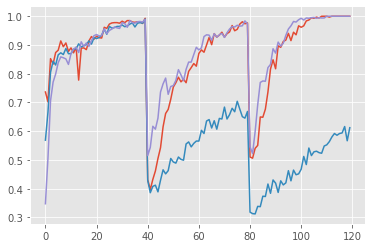

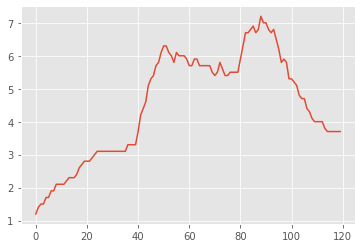

In [143]:

AvrDMW = np.asarray(AvrDMW)
AvrNoE = np.asarray(AvrNoE)
AvrNB = np.asarray(AvrNB)
AvrPF = np.asarray(AvrPF)


AccuDMW = np.zeros((120))
NoEu = np.zeros((120))
AccuNB = np.zeros((120))
AccuPF = np.zeros((120))

for i in range(AccuDMW.shape[0]):
  AccuDMW[i] = np.mean(AvrDMW[:,i])
  NoEu[i] = np.mean(AvrNoE[:,i])
  AccuNB[i] = np.mean(AvrNB[:,i])
  AccuPF[i] = np.mean(AvrPF[:,i])

plt.style.use("ggplot")
plt.figure(0)
plt.plot(np.arange(0, len(AccuDMW)), AccuDMW,label="acc")
plt.plot(np.arange(0, len(AccuDMW)), AccuNB,label="acc")
plt.plot(np.arange(0, len(AccuDMW)), AccuPF,label="acc")

plt.figure(1)
plt.plot(np.arange(0, len(NoEu)), NoEu,label="acc")
plt.show

## SEA CONCEPTS FOR DMW

In [26]:
def DMW2(concept = "Stagger",limit = False):
  
  #Initialization
  if concept == "Stagger":
    p = 1
    time = 120
    M = 5
  else:
    p = 5
    time = 5000
    M = 5

  
  c = [0,1]
  b = 0.5
  th = 0.01 
  accDMW = []
  NoE = []
  accNB = []
  accPer = []
  Experts = []
  Weights = []
  
  # Initializing experts
  Experts.append(newLearner(concept))
  Weights.append(1)
  NB = newLearner(concept)
  Perfect = newLearner(concept)
  
  # Slice a data frame to take the size of the dataset
  dummy_feature,dummy_label = createDataset(concept,1)
  
  
  # Train all the 3 methods with one random slice of the dataset
  Experts[0].partial_fit([np.random.choice(2,dummy_feature.shape[1])],[np.random.choice(2,1)],c)
  NB.partial_fit([np.random.choice(2,dummy_feature.shape[1])],[np.random.choice(2,1)],c)
  Perfect.partial_fit([np.random.choice(2,dummy_feature.shape[1])],[np.random.choice(2,1)],c)
  
  # Starting algorithm here
  for i in tqdm(range(time)):
    
    # Snapshot of dataset
    features , labels = createDataset(concept,i)
    
    # Split the dataset to training and testing:
    train,test = features[0],features[1:]
    train_label,test_labels = labels[0],labels[1:]
    # Update Perfect forgetting if needed
    if (concept == "Stagger" and (i == time/3 or i == time*2/3)) or (concept!="Stagger" and (i == time/4 or i == time*2/4 or i==time*3/4)):
      Perfect = newLearner(concept)
      Perfect.partial_fit([np.random.choice(2,dummy_feature.shape[1])],[np.random.choice(2,1)],c)
    
    #print("Timestep: {}".format(i))
    #print("Train vector: {}".format(train))
    #print()
    #print("With label: {}".format(train_label))
    
    
    # DMW for overal prediction 
    s = np.zeros(2)
    for j,e in enumerate(Experts):
      
      temp = int(e.predict([train]))
      
      if temp != train_label:
        Weights[j] *= b
      s[temp] = s[temp]+ Weights[j]
    #print("Printing s before doing the prediction:{}".format(s))
    predictionDMW = np.argmax(s)
    #print("DMW prediction = {}".format(predictionDMW))
    
    
    # Evaluate DMW for the rest of the dataset
    overalPred = np.zeros(len(test_labels))
    predictions = np.zeros((len(test_labels),2))
    for j,e in enumerate(Experts): 
      for f in range(len(test)):
        t = int(e.predict([test[f]]))
        predictions[f,t] += Weights[j]
    for f in range(len(overalPred)):
      overalPred[f] = np.argmax(predictions[f,:])
    accDMW.append(metrics.accuracy_score(test_labels, overalPred))  
    #print("Accuracy for DMW: {}".format(metrics.accuracy_score(test_labels, overalPred)))
    
    #Evaluate for Naive Bayes and Perfect Forgettting
    overalPredNB = np.zeros(len(test_labels))
    overalPredPF = np.zeros(len(test_labels))
    for j,f in enumerate(test):
      overalPredNB[j] = int(NB.predict([f]))
      overalPredPF[j] = int(Perfect.predict([f]))
    accNB.append(metrics.accuracy_score(test_labels, overalPredNB))  
    accPer.append(metrics.accuracy_score(test_labels, overalPredPF))    
    #print("Accuracy for NB: {}".format(metrics.accuracy_score(test_labels, overalPredNB)))
    #print("Accuracy for PF: {}".format(metrics.accuracy_score(test_labels, overalPredPF)))
    
    # Update DMW experts
    if (i % p == 0) and limit == False:
      #print("Weights before Normalization: {}".format(Weights))
      Weights = normalize(Weights)
      #print("Weights after Normalization: {}".format(Weights))
      
      Experts,Weights = remove_experts(Experts,Weights,th)
      
      if predictionDMW != train_label:
        #print("Adding new expert....")
        Experts.append(newLearner(concept))
        Weights.append(1)
    elif (i%p == 0) and limit == True:
      Weights = normalize(Weights)
      if predictionDMW != train_label and len(Experts) >= M:
        #print("Adding new expert....")
        replace_experts(Experts,Weights,concept)
      elif predictionDMW != train_label and len(Experts) < M:
        Experts.append(newLearner(concept))
        Weights.append(1)
      
      
    NoE.append(len(Experts))
    
    # Train for the given feature
    for j,expert in enumerate(Experts):
      expert.partial_fit([train],[train_label],c)
    NB.partial_fit([train],[train_label],c)
    Perfect.partial_fit([train],[train_label],c)
    
  return accDMW,NoE,accNB,accPer

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 15.46it/s]


<function matplotlib.pyplot.show(*args, **kw)>

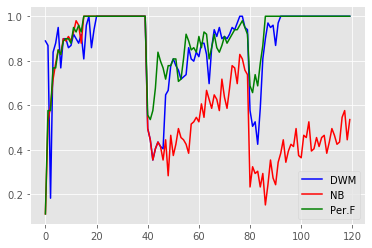

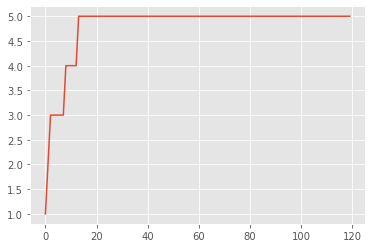

In [29]:
acc,NoE,accNB,accPer = DMW2("Stagger",limit=True)
plt.style.use("ggplot")
plt.figure(0)
plt.plot(np.arange(0, len(acc)), acc,label="DWM",color = "blue")
plt.plot(np.arange(0, len(acc)), accNB,label="NB",color = "red")
plt.plot(np.arange(0, len(acc)), accPer,label="Per.F",color = "green")
plt.legend()
plt.ylim(0.5,1)
plt.figure(1)
plt.plot(np.arange(0, len(NoE)), NoE,label="acc")
plt.show

In [30]:
AvrDMW =[]
AvrNoE = []
AvrNB = []
AvrPF = []

for z in range(10):
  print("Iteration: {}".format(z))
  acc,NoE,accNB,accPer = DMW2("Stagger",limit=True)
  AvrDMW.append(acc)
  AvrNoE.append(NoE)
  AvrNB.append(accNB)
  AvrPF.append(accPer)

  2%|██                                                                                | 3/120 [00:00<00:04, 24.85it/s]

Iteration: 0


  2%|██                                                                                | 3/120 [00:00<00:04, 27.59it/s]

Iteration: 1


  3%|██▋                                                                               | 4/120 [00:00<00:03, 31.83it/s]

Iteration: 2


  2%|██                                                                                | 3/120 [00:00<00:04, 27.35it/s]

Iteration: 3


  3%|██▋                                                                               | 4/120 [00:00<00:03, 32.09it/s]

Iteration: 4


  2%|██                                                                                | 3/120 [00:00<00:04, 25.93it/s]

Iteration: 5


  3%|██▋                                                                               | 4/120 [00:00<00:03, 31.83it/s]

Iteration: 6


  2%|██                                                                                | 3/120 [00:00<00:04, 25.71it/s]

Iteration: 7


  2%|██                                                                                | 3/120 [00:00<00:04, 28.92it/s]

Iteration: 8


  2%|██                                                                                | 3/120 [00:00<00:04, 24.46it/s]

Iteration: 9


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 15.47it/s]


<function matplotlib.pyplot.show(*args, **kw)>

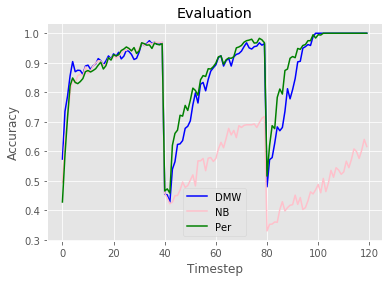

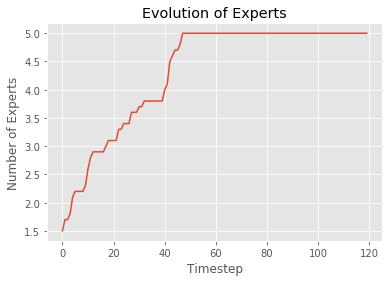

In [31]:
AvrDMW = np.asarray(AvrDMW)
AvrNoE = np.asarray(AvrNoE)
AvrNB = np.asarray(AvrNB)
AvrPF = np.asarray(AvrPF)


AccuDMW = np.zeros((120))
NoEu = np.zeros((120))
AccuNB = np.zeros((120))
AccuPF = np.zeros((120))

for i in range(AccuDMW.shape[0]):
  AccuDMW[i] = np.mean(AvrDMW[:,i])
  NoEu[i] = np.mean(AvrNoE[:,i])
  AccuNB[i] = np.mean(AvrNB[:,i])
  AccuPF[i] = np.mean(AvrPF[:,i])

plt.style.use("ggplot")
plt.figure(0)
plt.plot(np.arange(0, len(AccuDMW)), AccuDMW,label="DMW",color = "blue")
plt.plot(np.arange(0, len(AccuDMW)), AccuNB,label="NB",color = "pink")
plt.plot(np.arange(0, len(AccuDMW)), AccuPF,label="Per",color = "green")
plt.ylabel('Accuracy')
plt.xlabel("Timestep")
plt.title('Evaluation')
plt.legend()
plt.figure(1)
plt.plot(np.arange(0, len(NoEu)), NoEu,label="Learners")
plt.ylabel('Number of Experts')
plt.xlabel("Timestep")
plt.title('Evolution of Experts')
plt.show